## Respostas

### What does the data tell us ?

Os dados demonstram uma relação direta entre preço, quantidade e receita. Se há aumento de preço a quantidade demandada é menor, e consequentemente também a receita. 

### How are the different data sources related ?

Os dois conjuntos de dados estão relacionados através dos valores dos mesmos produtos vendidos pelos concorrentes e Marketplace.

### Is there a particular competitor that seems more important ?

Do total de 6 competidores, cinco(C1,C2,C3,C4,C6) respondem por 91.4% do conjunto 'comp_prices'. Mais da análise está disponível no arquivo 'competitors_stats_report.html'.


## Considerações

### O conjunto de dados(sales) é estacionário

*  Modelos de previsão com resultados significativos e confiáveis normalmente devem estar em um período de pelo menos 1 ano(completo), melhor ainda seriam dois, três ou mais anos. Somente assim é possível enxergar ciclos e tendências claras no conjunto de dados. Ou seja o conjunto de dados deve demonstrar um tendência **não-estacionária**.
* Este não é o caso do presente conjunto de dados, que somente contém dados até Outubro de um único ano, 2015, portanto incompleto.
* Sendo assim um modelo de previsão(demanda etc) baseado em uma série temporal torna-se inviável, dada as limitações citadas.
* O presente conjunto demonstra uma tendência temporal **estacionária**, com médias, variância praticamente constantes no tempo. O conjunto fornecido não apresenta médias móveis. 
*  Portanto séries temporais estacionárias como a do presente conjunto tem capacidade limitada de 'prever' e estão mais suscetíveis a erros(sasonalidade, acontecimentos imprevistos) e valores extremos. Abaixo na análise foi proposto um modelo de regressão, elasticidade de preço da demanda.



In [ ]:
!pip install chart-studio
!pip install pandas-profiling

In [118]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division

import warnings
warnings.filterwarnings("ignore")

import scipy.stats as stats
import pylab
import numpy as np
import seaborn as sns

import chart_studio.plotly.plotly as py
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro
from statsmodels.formula.api import ols
import plotly.graph_objects as go
import plotly.offline as pyoff

In [119]:
sales = '/content/drive/MyDrive/data_B2W/sales.csv'
#df = pd.read_csv(url)

df_sales = pd.read_csv(sales)

df_sales.head(4)

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
0,P6,2015-08-02,1.0,1808.99
1,P6,2015-08-17,1.0,1674.00
2,P6,2015-08-17,1.0,1673.95
3,P6,2015-08-11,1.0,1674.00


In [120]:
df_sales['DATE_ORDER'] = pd.to_datetime(df_sales['DATE_ORDER'])

In [121]:
sales_growth = df_sales[(df_sales['DATE_ORDER'].dt.strftime('%Y-%m-%d') >= '2015-01-01') & (df_sales['DATE_ORDER'].dt.strftime('%Y-%m-%d') <= '2015-10-30')]

In [122]:
#groupby date e somando 'REVENUE', variável contínua.
sales_growth = sales_growth.groupby('DATE_ORDER').REVENUE.sum().reset_index()

In [124]:
#gráfico mensal de 'REVENUE'
plot_data = [
    go.Scatter(
        x=sales_growth['DATE_ORDER'],
        y=sales_growth['REVENUE'],
    )
]
plot_layout = go.Layout(
        title='Vendas com tendência estacionária'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

*  O gráfico acima demonstra claramente não haver nenhuma tendência no conjunto(sales). Ou seja nenhum modelo é eficiente para explicar variações de maneira precisa. A média(e outros parâmetros) não é móvel.


#### Teste estatístico de estacionariedade

In [125]:
# extraindo valores
X = sales_growth.REVENUE

# aplicando ADF e imprimindo resultados
result = adfuller(X)
print('ADF')
print('Resultado do teste: {:.4f}'.format(result[0]))
print('P Value: {:.10f}'.format(result[1]))
print('Valores críticos:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

ADF
Resultado do teste: -3.6808
P Value: 0.0043908523
Valores críticos:
	1%: -3.4544
	5%: -2.8721
	10%: -2.5724


Tanto o valor do 'Resultado do teste', como 'p-value' são muito baixos, confirmando que o presente conjunto é **estacionário**. 
<br>Caso contrário o valor de p-value seria o responsável por confirmar a hipótese nula do teste acima de que o conjunto é **'não-estacionário'**

### Conjunto de dados 'Não-Gaussiano'.

Testes estatísticos de 'Normalidade'

#### Quantile-Quantile (QQ Plot)

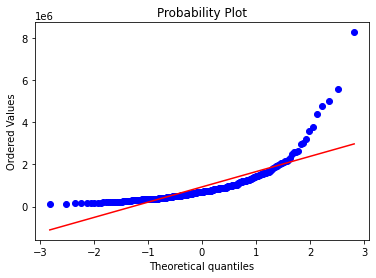

In [126]:
sales_growth = sales_growth['REVENUE']
stats.probplot(sales_growth, dist="norm", plot=pylab)
pylab.show()

O gráfico acima demonstra pontos azuis com pouca sobreposição a linha vermelha, demonstrando 'Não-Normalidade'. Com desvios nas extremidades.

#### Histograma

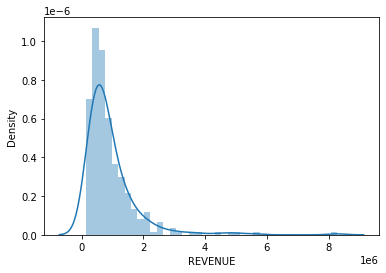

In [127]:
ax = sns.distplot(sales_growth)

O histograma acima também confirma uma distribuição bem assimétrica, tipo despenhadeiro, com muitos valores baixos a esquerda e poucos valores altos à direita. No relatório que acompanha junto com os arquivos 'sales_stats.html' é possível visualizar que estes representam menos de 0.1% do conjunto.

#### Teste de 'Normalidade' 

Confirma ou nega a hipótese nula de que a variável em questão tem distribuição 'Normal'. Se p-value > 0.05 a distribuição é 'Gaussiana', caso contrário se p-value < 0.05 é 'Não-Gaussiana'.

In [ ]:
stat , p = shapiro(sales_growth)
print('stat=%.3f , p=%.3f\n' % (stat,p))
if p > 0.05:
  print('Dsitribuição Gaussiana')
else:
  print('Distribuição não-Gaussiana')

stat=0.662 , p=0.000

Distribuição não-Gaussiana


## Alternativas

Antes de relacionar o conjunto 'sales' e 'comp_prices' e tentar criar um modelo. Mesmo considerando alguns tratamentos no conjunto de dados como realizado abaixo, o melhor seria um modelo de elasticidade de preço(o quão sensitivo é a demanda, com a mudança de preços), ao invés de previsão de demanda(já que esta leva em consideração mais fatores que somente preço).
<br><br>
Como o presente conjunto de dados é estacionário e 'Não-Gaussiano', poderia-se optar por:
  * 'Limpar' valores nulos, extremos
  * Checar presença de sobreposição de outro processo que gera distribuição bimodal ou multimodal.
  * Um modelo de demanda por 'Suavização Exponencial Simples(SES)'

  Ainda assim poderia-se incorrer em imprecisão e sobre-ajuste('overfitting'). 




Como o conjunto não apresenta valores nulos, nem valores '0'.

In [4]:
sales = '/content/drive/MyDrive/data_B2W/sales.csv'
#df = pd.read_csv(url)

df_sales = pd.read_csv(sales)

In [ ]:
df_sales.isnull().values.any()

False

In [ ]:
df_sales.isnull().sum()

PROD_ID       0
DATE_ORDER    0
QTY_ORDER     0
REVENUE       0
dtype: int64

Podemos filtrar valores mais discrepantes(gráfico QQ Plot), afastados nas pontas da linha referência(vermelha)

In [242]:
sales = '/content/drive/MyDrive/data_B2W/sales.csv'
#df = pd.read_csv(url)

df_sales = pd.read_csv(sales)
df_sales['DATE_ORDER'] = pd.to_datetime(df_sales['DATE_ORDER'])
df_sales.set_index('DATE_ORDER',inplace=True)
df_sales["REVENUE"] = pd.to_numeric(df_sales["REVENUE"], downcast="float")
df_sales["QTY_ORDER"] = pd.to_numeric(df_sales["REVENUE"], downcast="integer")
#df_sales[(df_sales['DATE_ORDER'].dt.strftime('%Y-%m-%d') >= '2015-01-01') & (df_sales['DATE_ORDER'].dt.strftime('%Y-%m-%d') <= '2015-10-30')]
#df_sales.groupby('DATE_ORDER').REVENUE.sum()



### Limpeza

Pode levar a possível 'overfitting'.

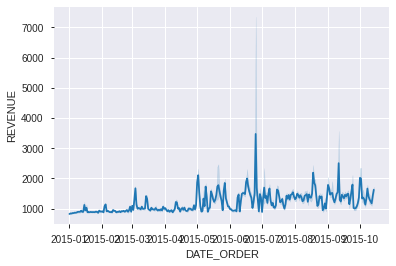

In [243]:
rev_graph = df_sales.query("REVENUE > 794.320007")
sns.lineplot(data=rev_graph, x="DATE_ORDER", y="REVENUE")

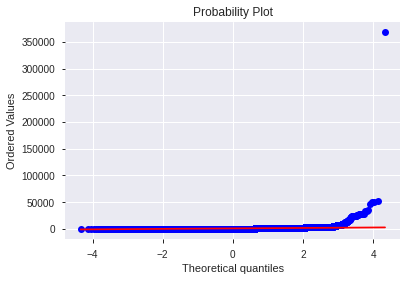

In [244]:
sales_norm = rev_graph['REVENUE']
stats.probplot(sales_norm, dist="norm", plot=pylab)
pylab.show()

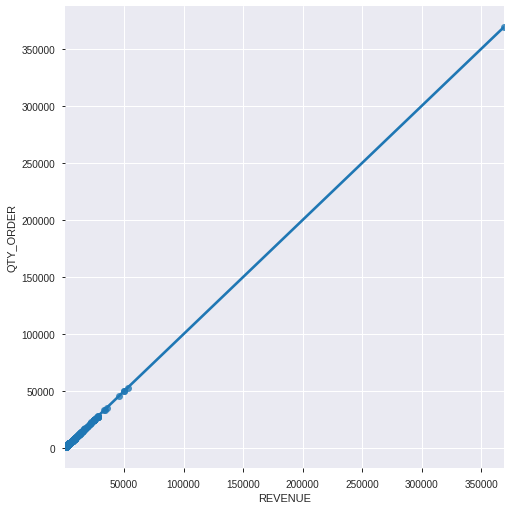

In [245]:
sns.lmplot(x = "REVENUE", y = "QTY_ORDER", 
data = rev_graph, size = 7)

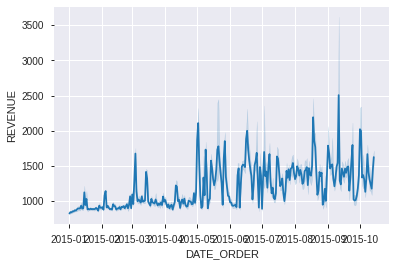

In [246]:
rev_graph2 = rev_graph.query("REVENUE < 149900.0")
sns.lineplot(data=rev_graph2, x="DATE_ORDER", y="REVENUE")

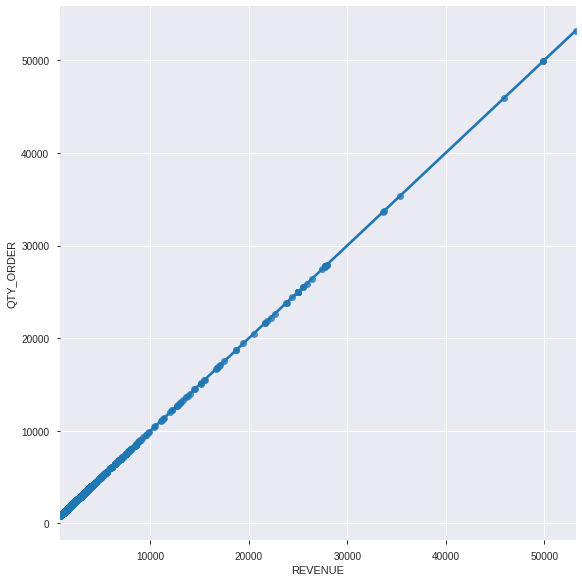

In [248]:
sns.lmplot(x = "REVENUE", y = "QTY_ORDER", data = rev_graph2, size = 8)

## Competidores 

In [161]:
sales = '/content/drive/MyDrive/data_B2W/sales.csv'
#df = pd.read_csv(url)

df_sales = pd.read_csv(sales)
df_sales['DATE_ORDER'] = pd.to_datetime(df_sales['DATE_ORDER'])

In [162]:
comp = '/content/drive/MyDrive/data_B2W/comp_prices.csv'
#df = pd.read_csv(url)

df_comp = pd.read_csv(comp)

### Preço médio por produto e tipo de pagamento

In [60]:
comp_group = df_comp.groupby(['PROD_ID', 'PAY_TYPE'])
#comp_group.groups.keys()

Preço médio dos competidores por produto e tipo de pagamento.

In [61]:
agg_comp = comp_group['COMPETITOR_PRICE'].mean()
agg_comp

PROD_ID  PAY_TYPE
P1       1           1957.185088
         2           1857.754339
P2       1            833.078963
         2            806.673032
P3       1           1438.984799
         2           1404.235583
P4       1            644.202994
         2            641.849976
P5       1           1149.409673
         2           1135.170116
P6       1           1964.836399
         2           1938.351220
P7       1            913.023601
         2            873.836675
P8       1            511.403486
         2            507.614784
P9       1            543.339024
         2            524.027908
Name: COMPETITOR_PRICE, dtype: float64

A média de preço de cada produto por tipo de pagamento. O tipo de pagamento 1(deferred payment) apresenta preço médio mais elevado em todos os produtos.

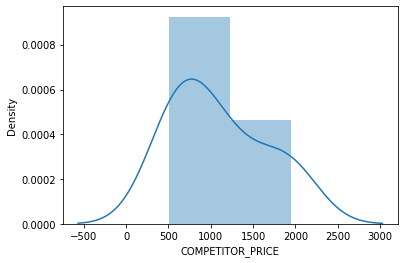

In [41]:
ax = sns.distplot(agg_comp)

### Receita média por produto

In [100]:
sales_group = df_sales.groupby('PROD_ID')
#sales_group.groups.keys()

Receita média dos vendedores por produto.

In [101]:
agg_sales = sales_group['REVENUE'].mean()
agg_sales

PROD_ID
P1    1470.079868
P2     726.308993
P3    1281.190048
P4     577.012720
P5     804.431663
P6    1725.870236
P7     822.920101
P8     436.698291
P9     432.906599
Name: REVENUE, dtype: float64

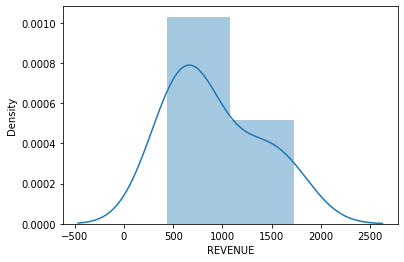

In [72]:
ax = sns.distplot(agg_sales)

Comparando as duas médias acima, constata-se não só maiores preços praticados pelos concorrentes em todos os produtos como também um possível aumento nos preços dos produtos dos vendedores(marketplace), para aumentar receita, nos produtos P1, P5, P6, P3 e P9, principalmente no tipo de pagamento 1.
<br>Quanto menor a diferença maior a receita em todos os produtos.

In [74]:
diff = agg_comp - agg_sales
diff

PROD_ID  PAY_TYPE
P1       1           487.105220
         2           387.674471
P2       1           106.769970
         2            80.364039
P3       1           157.794750
         2           123.045535
P4       1            67.190274
         2            64.837256
P5       1           344.978010
         2           330.738453
P6       1           238.966163
         2           212.480983
P7       1            90.103499
         2            50.916574
P8       1            74.705196
         2            70.916494
P9       1           110.432425
         2            91.121309
dtype: float64

## Modelo


Análise dos dois conjuntos 'sales' e 'comp_prices'






In [78]:
sales = '/content/drive/MyDrive/data_B2W/sales.csv'

df_sales = pd.read_csv(sales)
df_sales['DATE_ORDER'] = pd.to_datetime(df_sales['DATE_ORDER'])
#df_sales['PROD_ID'] = df_sales.index

comp = '/content/drive/MyDrive/data_B2W/comp_prices.csv'

df_comp = pd.read_csv(comp)
#df_comp['PROD_ID'] = df_comp.index

In [79]:
sales_comp = df_comp.merge(df_sales, on='PROD_ID', how='left', left_index=True, right_index=True)

In [5]:
sales_comp.head(4)

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE_ORDER,QTY_ORDER,REVENUE
0,P6,2015-01-30 08:11:38,C3,1898.00,1,2015-08-02,1.0,1808.99
1,P6,2015-01-30 08:11:38,C1,1898.00,1,2015-08-17,1.0,1674.00
2,P6,2015-01-30 08:11:38,C6,1999.90,1,2015-08-17,1.0,1673.95
3,P6,2015-01-31 20:10:14,C2,1894.88,2,2015-08-11,1.0,1674.00


In [73]:
df_group = sales_comp.groupby(['PROD_ID', 'PAY_TYPE', 'COMPETITOR'])

Comparação entre produto, tipo de pagamento, preço do competidor, receita e quantidade.

In [77]:
agg_price = df_group['COMPETITOR_PRICE', 'REVENUE', 'QTY_ORDER'].mean()
pd.set_option('max_rows', 99999)
agg_price

COMPETITOR_PRICE      REVENUE  QTY_ORDER
PROD_ID PAY_TYPE COMPETITOR                                          
P1      1        C1               1923.770339   876.745483   1.075718
                 C2               1974.177813   898.389943   1.096591
                 C3               2226.752121   871.013182   1.070707
                 C5               1914.518768   859.192689   1.053221
                 C6               1496.508824   858.161912   1.058824
        2        C1               1819.925209   870.848953   1.062827
                 C2               1925.133390   851.611054   1.045584
                 C3               2048.249545   866.528737   1.060606
                 C5               1794.965927   898.147949   1.101124
                 C6               1496.508824   846.327059   1.029412
P2      1        C1                852.174403   879.626043   1.081996
                 C2                849.995869   862.002057   1.065603
                 C3                771.000469   870.889751   1.070813
                 C4                848.236878   873.568337   1.073469
                 C5                831.793522   901.444251   1.105263
                 C6                863.711446   869.582485   1.072301
        2        C1                812.700178   875.460036   1.076649
                 C2                822.898777   889.915851   1.095745
                 C3                749.668247   876.242864   1.080460
                 C4                814.737763   892.635506   1.108274
                 C5                737.671336   855.985628   1.048583
                 C6                863.888624   868.610459   1.068298
P3      1        C1               1346.443167   860.735971   1.089806
                 C2               1341.941366   871.805526   1.100363
                 C3               1492.536077   821.190742   1.038278
                 C4               1702.369469   840.519406   1.062500
                 C5               1471.997902   819.113357   1.041958
                 C6               1552.353693   852.457638   1.077889
        2        C1               1309.980827   862.883175   1.093674
                 C2               1329.121891   830.993079   1.053333
                 C3               1446.021031   862.942302   1.093525
                 C4               1641.930094   854.918589   1.084639
                 C5               1314.584406   829.465524   1.069930
                 C6               1552.893627   859.498463   1.088161
P4      1        C4                604.833204   864.133959   1.099448
                 C5                569.000000   857.012500   1.125000
                 C6                718.962925   836.545136   1.064626
        2        C4                602.188266   855.726181   1.088561
                 C5                495.030000   799.000000   1.000000
                 C6                718.962925   887.714660   1.125850
P5      1        C1               1158.593694   907.831943   1.146497
                 C2               1156.689119   903.779465   1.144654
                 C3               1132.958259   893.207215   1.129747
        2        C1               1148.972102   835.967930   1.054140
                 C2               1138.950346   844.713459   1.066038
                 C3               1117.651329   914.760886   1.151899
P6      1        C1               1901.759529  1190.826986   1.053394
                 C2               1924.683940  1169.506676   1.044818
                 C3               1887.772539  1163.528513   1.036011
                 C4               2007.682941  1191.054235   1.085714
                 C6               2150.953839  1221.376031   1.047983
        2        C1               1870.672081  1171.460398   1.043439
                 C2               1890.217582  1147.337983   1.034547
                 C3               1864.488006  1174.973813   1.048015
                 C4               1957.466908  1151.540941   1.053782
                 C6               2150.

### Comparativo de demanda

Como é possível ver abaixo, utilizando o preço médio praticado entre competidores com a quantidade vendida obtém-se uma reta com todos os preços e quantidades que mais favorecem aumento de receita.

In [98]:
avg_comp_price = sales_comp['COMPETITOR_PRICE'].mean()

In [81]:
sales_comp["AVG_REVENUE"] = (sales_comp["QTY_ORDER"] * avg_comp_price)

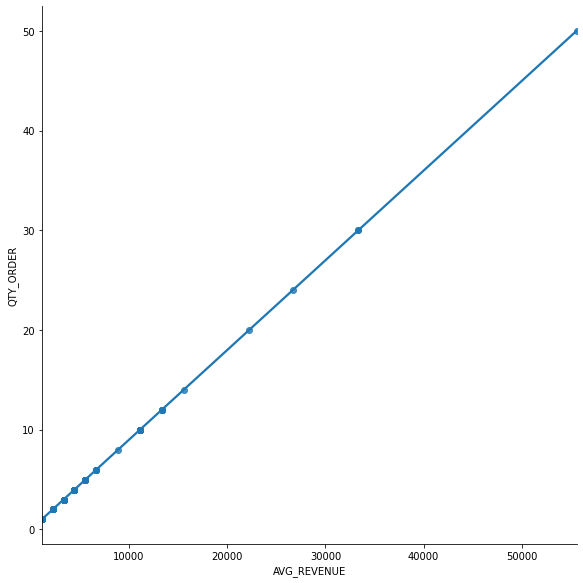

In [83]:
sns.lmplot(x = "AVG_REVENUE", y = "QTY_ORDER", data = sales_comp, size = 8)

Ao contrário no grágico abaixo é observado maior dispersão dos pontos em relação a reta nos preços praticados pelos vendedores quando estes não alinham seus preços ao preço dos competidores. Principalmente quando se trata de maiores quantidades e preços mais altos.

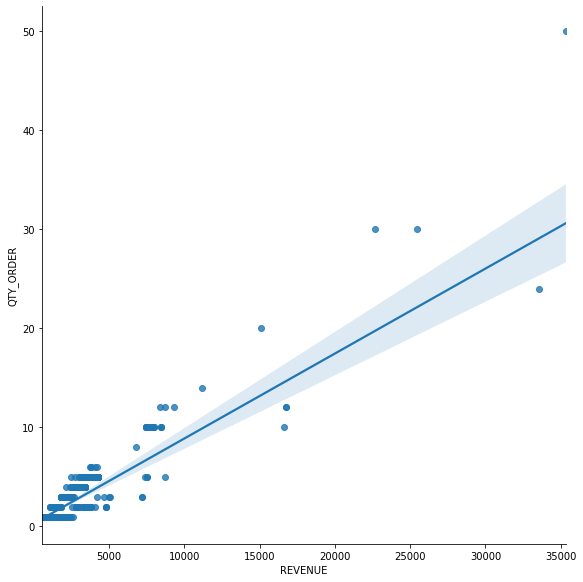

In [53]:
sns.lmplot(x = "REVENUE", y = "QTY_ORDER", data = sales_comp, size = 8)

### Regressão e Elasticidade

Para obter preço ótimo, será aplicado o modelo de regressão 'Ordinary Least Square(OLS) a curva de demanda encontrada acima. Este modelo fornece as estatísticas, coeficiente e interceptação necessários para obter as equação da função lucro.

* Receita
<br> receita = quant * preco  | eq (1)
* Lucro
<br> lucro = receita - custo  | eq (2)
<br> lucro = quant * preco - custo  | eq (3)

In [85]:
sales_comp.astype({"QTY_ORDER": int}).head(3)

,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE,DATE_ORDER,QTY_ORDER,REVENUE,AVG_REVENUE
0,P6,2015-01-30 08:11:38,C3,1898.0,1,2015-08-02,1,1808.99,1111.281449
1,P6,2015-01-30 08:11:38,C1,1898.0,1,2015-08-17,1,1674.00,1111.281449
2,P6,2015-01-30 08:11:38,C6,1999.9,1,2015-08-17,1,1673.95,1111.281449


In [88]:
sales_comp["PRICE"] = ( sales_comp["REVENUE"] / sales_comp["QTY_ORDER"])

In [89]:
model = ols("QTY_ORDER ~ PRICE", data = sales_comp).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              QTY_ORDER   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     50.14
Date:                Sun, 20 Jun 2021   Prob (F-statistic):           1.45e-12
Time:                        16:00:32   Log-Likelihood:                -38307.
No. Observations:               50114   AIC:                         7.662e+04
Df Residuals:                   50112   BIC:                         7.664e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1268      0.008    139.808      0.0

* Inserindo os coeficientes de regressão
<br> quant = 1.1268 - 6.411 * preco | eq (5)
* A função lucro na eq (3) fica
<br> lucro = (1.1268 - 6.411 * preco) * preco - custo | eq (6)

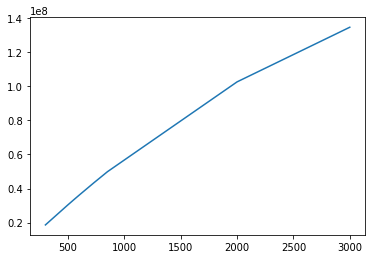

In [73]:
# um possível intervalo de diferentes preços para encontrar preço ótimo
Preco = [300, 499, 550, 600, 730, 850, 2000, 3000]
# assumindo custo fixo(hipotético)
custo = 10000
Receita = []
for i in Preco:
   quantidade_demandada = 1.268 - 6.411 * i
   
   # funcao lucro
   Receita.append((i-cost) * quantidade_demandada)
# um dataframe de preco e receita
lucro = pd.DataFrame({"Preco": Preco, "Receita": Receita})
# gráfico receita vs preco
plt.plot(lucro["Preco"], lucro["Receita"])

Na curva acima(caso o conjunto de dados não fosse tão homogêneo) o modelo encontraria um coeficiente e interceptação ótimo para obter lucro através de receita máxima. No entanto a receita apresentada no conjunto não gera margem suficiente.

Caso houvese margem o código abaixo encontraria a receita máxima através dos diferentes níveis de preço.
<br>
* profit[profit['Revenue'] == profit[['Revenue'].max()]]

## SQL

Queries executadas no BigQuery

Média de receita(vendedores) agrupada por produto
<br> [Gráfico](https://datastudio.google.com/reporting/5f6b764a-7647-4985-a4c4-12d1f3319a8b)

In [ ]:
SELECT PROD_ID, ROUND(AVG(REVENUE), 2) as AVG_REVENUE
FROM `pyanalysis.b2w_data.sales`
GROUP BY PROD_ID

Média de receita(vendedores) por semana
<br>[Gráfico](https://datastudio.google.com/reporting/a8f4f19c-e06a-4117-98b2-e67f4d7a55d3)

In [ ]:
SELECT ROUND(AVG(REVENUE), 2) as AVG_REVENUE,
 EXTRACT(WEEK FROM DATE_ORDER) as week_number
FROM `pyanalysis.b2w_data.sales`
GROUP BY week_number

Média preço(competidores) por semana
<br>[Gráfico](https://datastudio.google.com/reporting/9ff8b6f3-dcbb-46e9-a005-005f3b8f7467)

In [ ]:
SELECT ROUND(AVG(COMPETITOR_PRICE), 2) as AVG_REVENUE,
 EXTRACT(WEEK FROM DATE_EXTRACTION) as week_number
FROM `pyanalysis.b2w_data.comp_prices`
GROUP BY week_number

Média preço(competidores) por categoria
<br>[Gráfico](https://datastudio.google.com/reporting/23e75272-e43e-49cd-863a-79d668fd1c00)

In [ ]:
SELECT COMPETITOR, ROUND(AVG(COMPETITOR_PRICE), 2) as AVG_REVENUE,
FROM `pyanalysis.b2w_data.comp_prices`
GROUP BY COMPETITOR
